# Impulse Response (IR): Plotting Functions

In [35]:
import sys
# sys.path.append('../')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
from scipy import signal
mpl.rcParams['lines.linewidth'] = 1         # Set the default linewidth  
mpl.rcParams['font.size'] = 10              # Set the default linewidth
mpl.style.use('default')                                     

We read the IR of the BX25 spring reverb and plot it with different templates.

In [36]:
input_path = "./audio/IR_AKG_BX25_3500ms_48kHz24b.wav"
sample_rate, data = wavfile.read(input_path)
# data, sample_rate = sf.read(input_path)
print(f'Input dtype: {data.dtype}, sample rate: {sample_rate}')
print(f'Input shape: {data.shape}, min:{data.min():.6f}, max:{data.max():.6f}, mean:{data.mean():.6f}')

Input dtype: int32, sample rate: 48000
Input shape: (269190,), min:-2147483648.000000, max:1472520704.000000, mean:-2165.042565


In [37]:
"""
DC offset removal and normalization:
This file has been already normalized and the DC offset removed.
These function are here just for reference, but they are not in the pipeline.
"""

data = data - data.mean()            # Remove DC offset

data = data / np.abs(data).max()   # Normalize to [-1, 1]

## Waveform with Zoom

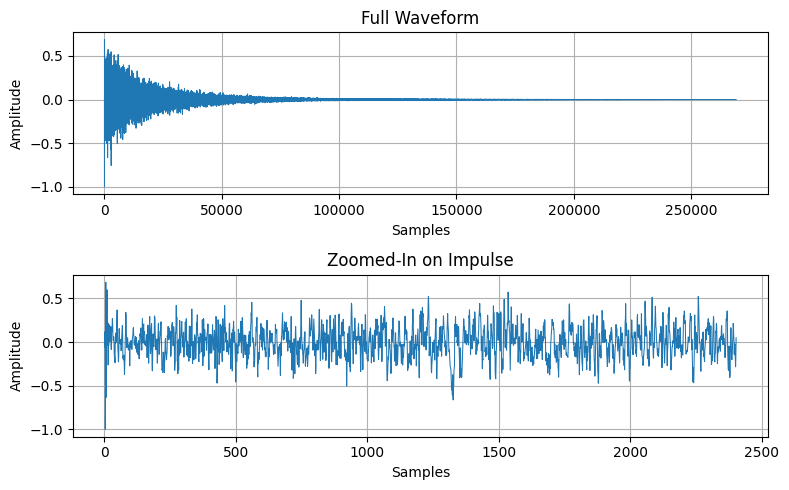

In [38]:
def plot_impulse_with_zoom(data, sample_rate, zoom_factor=0.1):
    """
    Plot the waveform and zoom in on the impulse.

    Parameters:
    - data: The impulse signal data.
    - sample_rate: The sample rate of the data.
    - zoom_factor: The fraction of the total duration to show around the impulse.
    """

    # Identify where the impulse is (find the sample with the highest absolute amplitude)
    impulse_index = np.argmax(np.abs(data))

    # Compute the number of samples to show around the impulse for zooming
    samples_to_show = int(sample_rate * zoom_factor)

    # Define start and end indices for the zoomed view
    start_index = max(0, impulse_index - samples_to_show // 2)
    end_index = min(len(data) - 1, impulse_index + samples_to_show // 2)

    # Create plots
    fig, axs = plt.subplots(2, 1, figsize=(8, 5))

    # Full waveform
    axs[0].plot(data, linewidth=0.75)
    axs[0].set_title("Full Waveform")
    axs[0].set_xlabel("Samples")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid()

    # Zoomed-in waveform
    axs[1].plot(range(start_index, end_index), data[start_index:end_index], linewidth=0.75)
    axs[1].set_title("Zoomed-In on Impulse")
    axs[1].set_xlabel("Samples")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid()

    plt.tight_layout()
    plt.show()

# Test with the impulse signal from the previous code snippet
plot_impulse_with_zoom(data, sample_rate)

## Waveform, Zoom and Spectrogram

In [39]:
def plot_impulse_and_spectrogram(data, sample_rate, zoom_factor=0.5):
    """
    Plot the waveform, zoom in on the impulse, and display its traditional spectrogram.

    Parameters:
    - data: The impulse signal data.
    - sample_rate: The sample rate of the data.
    - zoom_factor: The fraction of the total duration to show around the impulse.
    """
    # Identify where the impulse is (find the sample with the highest absolute amplitude)
    impulse_index = np.argmax(np.abs(data))

    # Compute the number of samples to show around the impulse for zooming
    samples_to_show = int(sample_rate * zoom_factor)

    # Define start and end indices for the zoomed view
    start_index = max(0, impulse_index - samples_to_show // 2)
    end_index = min(len(data) - 1, impulse_index + samples_to_show // 2)

    # Extract zoomed data
    zoomed_data = data[start_index:end_index]

   # Compute the spectrogram of the zoomed data with a larger window for better frequency resolution
    signal.get_window('blackman', 256)
    # nperseg = int(0.1 * sample_rate)
    f, t, Sxx = signal.spectrogram(zoomed_data, fs=sample_rate, window='blackman', mode='magnitude', scaling='spectrum')

    # Create plots
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    # Full waveform
    axs[0].plot(data)
    axs[0].set_title("Full Waveform")
    axs[0].set_xlabel("Samples")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid()

    # Zoomed-in waveform
    axs[1].plot(range(start_index, end_index), zoomed_data)
    axs[1].set_title("Zoomed-In on Impulse")
    axs[1].set_xlabel("Samples")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid()

    # Traditional spectrogram
    # cmap = plt.get_cmap('inferno')
    Sxx_dB = 10 * np.log10(np.abs(Sxx))
    max_mag = np.max(Sxx_dB)
    min_mag = max_mag - 70              # Dynamic range of 60 dB
    img = axs[2].pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap='inferno', norm=plt.Normalize(vmin=min_mag, vmax=max_mag))
    axs[2].set_yscale('log')            # Logarithmic scale for frequencies
    axs[2].set_ylim(f[1], f[-1])        # Exclude DC (0 Hz)
    fig.colorbar(img, ax=axs[2], format="%+2.0f dB")
    axs[2].set_title("Spectrogram")
    axs[2].set_ylabel("Frequency [Hz]")
    axs[2].set_xlabel("Time [sec]")
    
    # Set x-axis ticks
    custom_ticks = [20,100, 200, 400, 1000, 2000, 4000, 8000]
    plt.yticks(custom_ticks, custom_ticks)

    plt.tight_layout()
    plt.show()

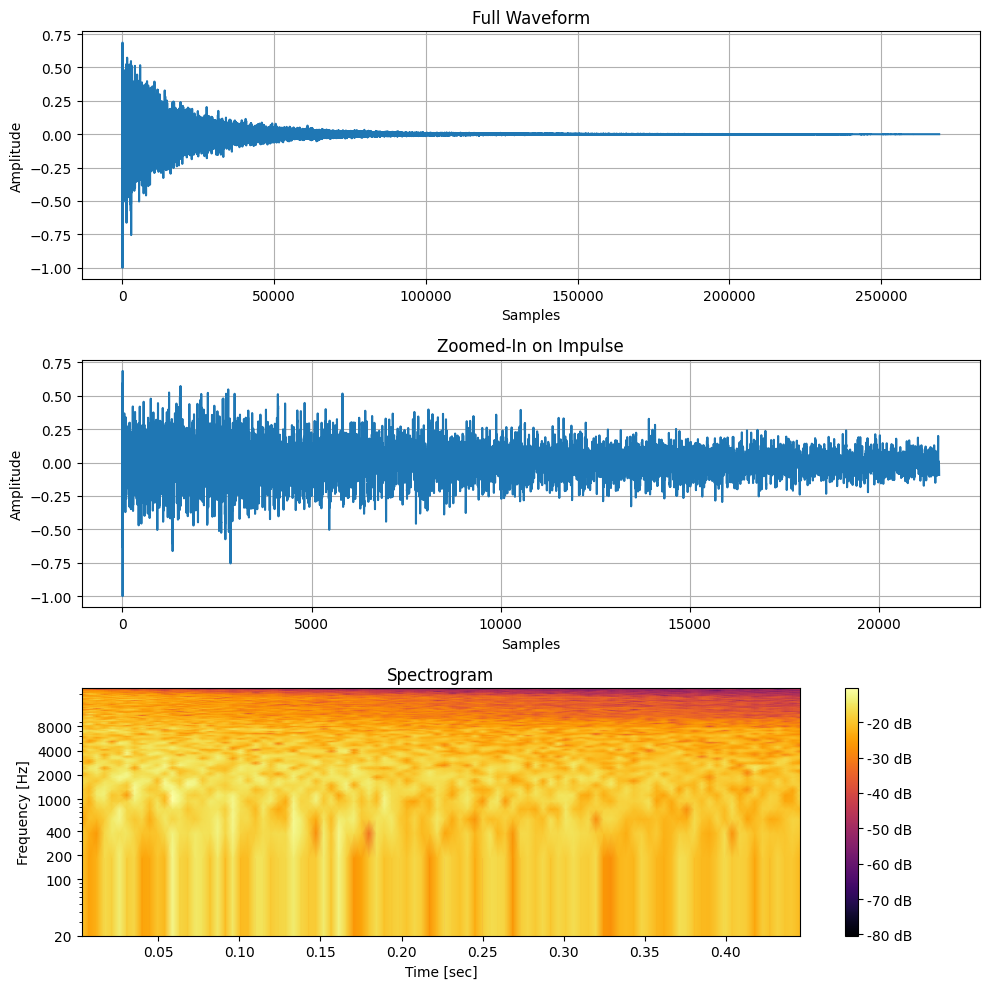

In [40]:
plot_impulse_and_spectrogram(data, sample_rate, zoom_factor=0.9)

## Waterfall Plot

In [41]:
def generate_spectrogram(waveform, sample_rate):
    frequencies, times, Sxx = signal.spectrogram(
        waveform, 
        fs=sample_rate, 
        window='blackmanharris',
        nperseg=32,
        noverlap=16,  
        scaling='spectrum', 
        mode='magnitude'
    )
    
    # Convert magnitude to dB
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)
    
    return frequencies, times, Sxx_dB

def plot_waterfall(waveform, title, sample_rate, stride=1):
    frequencies, times, Sxx = generate_spectrogram(waveform, sample_rate)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    X, Y = np.meshgrid(frequencies, times[::stride])
    Z = Sxx.T[::stride]

    surf = ax.plot_surface(X, Y, Z, 
                           cmap='inferno',
                           edgecolor='none', 
                           alpha=0.8,
                           linewidth=0,
                            antialiased=False)

    # Add a color bar which maps values to colors
    ax.autoscale()  # Adjusts the viewing limits for better visualization
    cbar = fig.colorbar(surf, ax=ax, pad=0.01, aspect=35, shrink=0.5)
    cbar.set_label('Magnitude (dB)')

    # Set labels and title
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (seconds)')
    ax.set_zlabel('Magnitude (dB)')
    # ax.set_title(title)
    
    ax.set_xlim([frequencies[-1], frequencies[0]])
    # ax.set_xscale('symlog', linthreshx=0.01)
    # ax.set_xscale('log')
    # ax.set_xlim([20000, 20])  # Set the x-axis limit to be between 20 and 20,000 Hz in log scale
    ax.view_init(elev=10, azim=45, roll=None, vertical_axis='z')  # Adjusts the viewing angle for better visualization
    
    plt.tight_layout()

(134595,) 134595


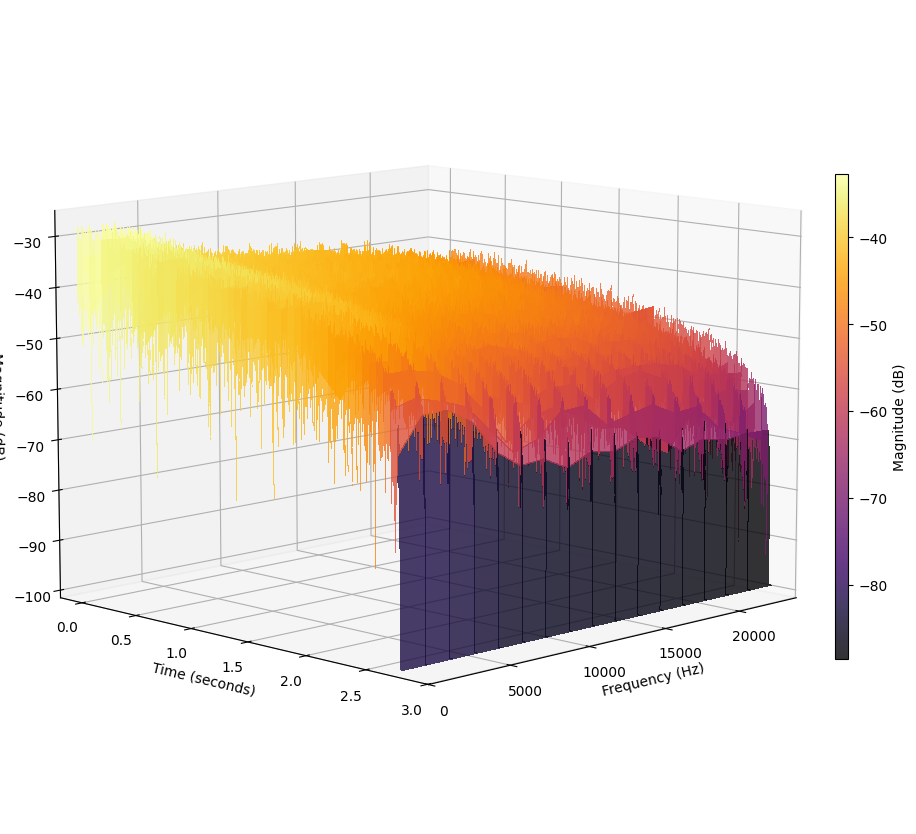

In [42]:
title = 'Waterfall Plot of the Impulse Response'
data = data
index = len(data) // 2
input = data[index:]
print(input.shape, index)
plot_waterfall(input, title, sample_rate, stride=1)

(134595,) -0.006336402462802971 0.005951703492671309 2.352945489334609e-07


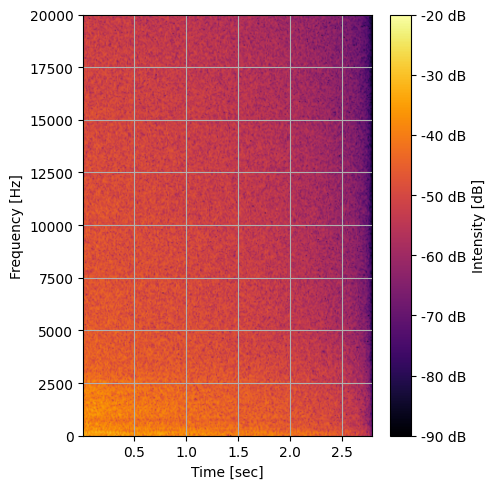

In [43]:
signal.get_window('blackman', 512)

impulse_response = input.reshape(-1)
print(impulse_response.shape, impulse_response.min(), impulse_response.max(), impulse_response.mean())
frequencies, times, Sxx = signal.spectrogram(impulse_response, fs=sample_rate, window='blackman', nperseg=1024, noverlap=512, mode='magnitude', scaling='spectrum')

# Convert the magnitude to dB scale:
Sxx_dB = 10 * np.log10(np.abs(Sxx) + 1e-10)

fig, ax = plt.subplots(figsize=(5, 5))

cax = ax.pcolormesh(times, frequencies, Sxx_dB, antialiased=True, shading='gouraud', cmap='inferno', norm=plt.Normalize(vmin=-90, vmax=-20))

# Add the colorbar
cbar = fig.colorbar(mappable=cax, ax=ax, format="%+2.0f dB")

ax.grid(True)
cbar.set_label('Intensity [dB]')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.set_ylim(0, 20000)
plt.tight_layout()
plt.show()

In [44]:
sample_rate, sweep = wavfile.read('./audio/log_sweep_tone.wav')
print(f'Sweep dtype: {sweep.dtype}, sample rate: {sample_rate}')
print(f'Sweep shape: {sweep.shape}, min:{sweep.min():.6f}, max:{sweep.max():.6f}, mean:{sweep.mean():.6f}', 'end=\n\n')

sample_rate, impulse_response = wavfile.read('./audio/ir_reference.wav')
print(f'IR dtype: {impulse_response.dtype}, sample rate: {sample_rate}')
print(f'IR shape: {impulse_response.shape}, min:{impulse_response.min():.6f}, max:{impulse_response.max():.6f}, mean:{impulse_response.mean():.6f}')

Sweep dtype: int32, sample rate: 48000
Sweep shape: (240000,), min:-2147483648.000000, max:2147483392.000000, mean:3418140.397867 end=


IR dtype: int32, sample rate: 48000
IR shape: (479999,), min:-7513856.000000, max:2147483392.000000, mean:45.643828


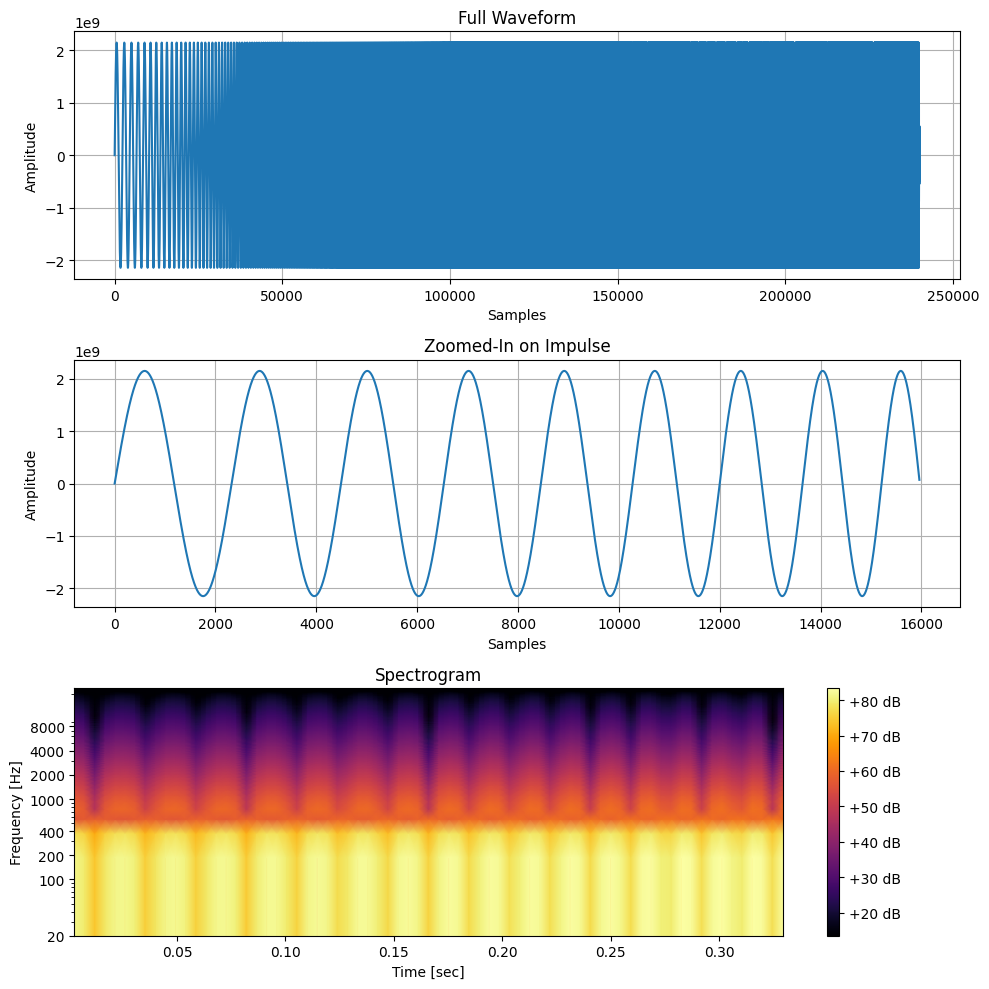

In [45]:
plot_impulse_and_spectrogram(sweep, sample_rate, zoom_factor=0.5)

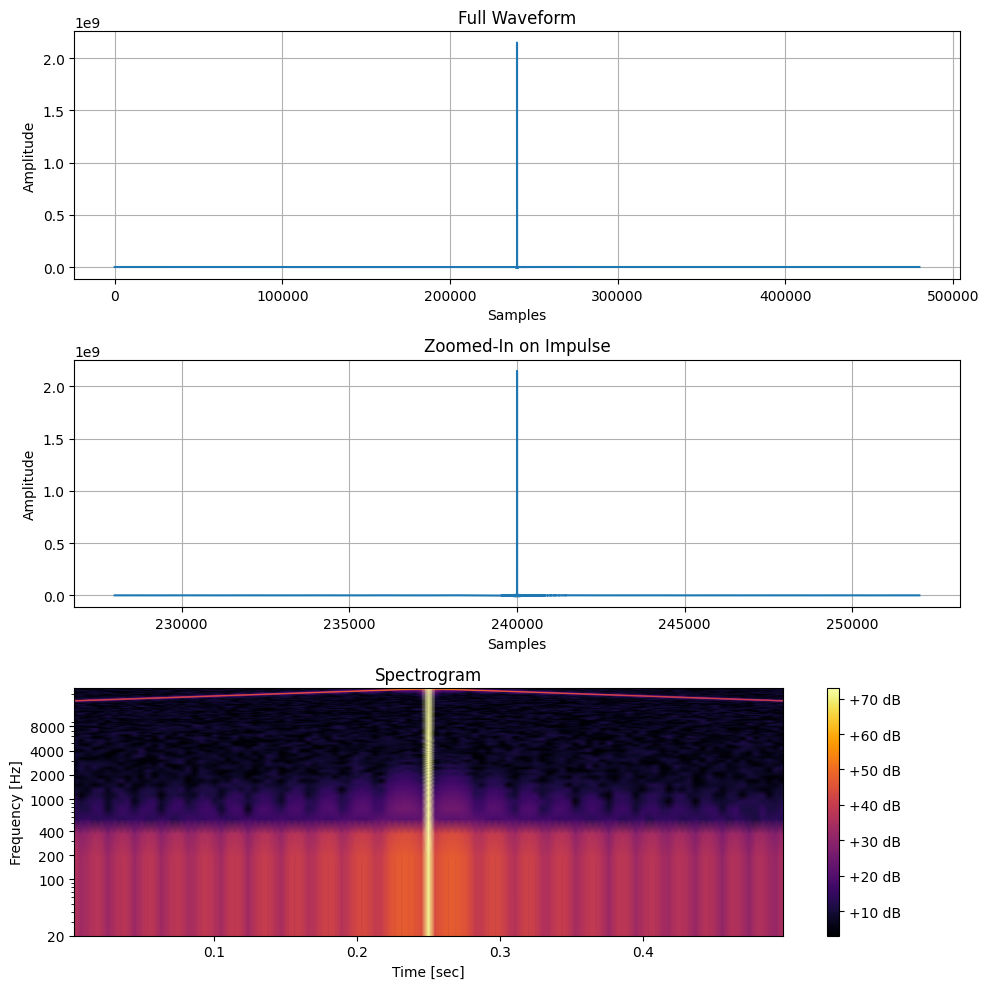

In [46]:
plot_impulse_and_spectrogram(impulse_response, sample_rate, zoom_factor=0.5)